# YOLO on TensorFlow

This notebook aims to create a trainable and usable version of YOLO on TensorFlow.

In [1]:
# *** IMPORT ***
import tensorflow as tf
from tf_yolo_utils import *   # fcts. to create custom layers

# Import kitti_utils from a different project
import sys
sys.path.insert(0, '/data2/lucas/Projects/Kitti2012')
from kitti_utils import *    # fcts. to manage the kitti dataset

In [2]:
print_labels(import_labels(700, 'train'))

----------------------------------------------------------------------
|type            |  x_max     |  y_min     |  y_max     |  x_min     |
----------------------------------------------------------------------
----------------------------------------------------------------------
|Car             |  600.06    |  176.1     |  190.53    |  581.85    |
----------------------------------------------------------------------
|Car             |  399.96    |  183.14    |  243.71    |  292.06    |
----------------------------------------------------------------------
|DontCare        |  576.27    |  166.69    |  188.61    |  559.56    |
----------------------------------------------------------------------
|DontCare        |  603.36    |  162.52    |  177.15    |  574.15    |
----------------------------------------------------------------------
|DontCare        |  624.18    |  161.48    |  175.06    |  609.56    |
----------------------------------------------------------------------


## The YOLO Architecture
![The YOLO Architecture](doc_img/YOLO_architecture.png)

The YOLO Detection network has 24 convolutional layers followed by 2 fully connected layers.

The predictions are encoded as an S x S x (B * 5 + C) tensor where S x S is the size of the grid that divides the input images. B is the number of boxes in one cell grid, C the number of conditional class probabilites.

N.B. __IoU (Intersection over Union)__ is an evaluation metric used to measure the accuracy of an object detector on a particular dataset.

![Intersection over Union Illustration](doc_img/iou_equation+examples.png)
_Source:[pyimagesearch.com](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)_ 

In [3]:
# --- HYPERPARAMETERS ---
TRAIN_PERC = 60   # Percentage of the data to put in the training set
DEV_PERC = 20     # Percentage of the data to put in the dev set
TEST_PERC = 20    # Percentage of the data to put in the test set

SEED = 42         # Seed used to randomize the dataset

BATCH_SIZE = 50   # Size of a batch of data
STEPS = 5000      # Number of step to train the CNN

IM_SIZE = 448     # 448=7*64  (Original shape of the image=(375, 1242, 3))
S = 7             # S x S grid the image is divided into
B = 2             # B = number of boxes per cell grid

# List of all the possible classes
LIST_CLASSES = ['Car', 'Van', 'Truck',
                'Pedestrian', 'Person_sitting', 
                'Cyclist', 'Tram', 'Misc', 
                'DontCare']

C = len(LIST_CLASSES)  # C = number of labelled classes

# --- IMPORT DATA ---
ids_for_training = get_data_list('train')
train_batches_ids, dev_batches_ids, test_batches_ids = prepare_dataset(ids_for_training, [TRAIN_PERC, DEV_PERC, TEST_PERC], BATCH_SIZE, SEED)

# --- IMPORT BATCH ---
# Function to import the images in the batches and to format the labels
# - TODO -

# We verify the network with the one made by others
# https://github.com/johnwlambert/YoloTensorFlow229/blob/master/yolo.py

# --- DEFINE CNN ---
x = tf.placeholder(tf.float32, shape=[None, IM_SIZE, IM_SIZE, 3])
y = tf.placeholder(tf.float32, shape=[None, S * S * (B * 5 + C)])

# --- CONV. LAYER 1 ---
# 7x7x64-s-2
# Maxpool: 2x2-s-2

conv1 = conv_layer(x, shape=[7, 7, 3, 64], strides=[1,2,2,1])
conv1_pool = max_pool_2x2(conv1)

# --- CONV. LAYER 2 ---
# 3x3x192
# Maxpool: 2x2-s-2

conv2 = conv_layer(conv1_pool, shape=[3, 3, 64, 192], strides=[1,2,2,1])
conv2_pool = max_pool_2x2(conv2)

# --- CONV. LAYERS 3 ---
# 1x1x128
# 3x3x256
# 1x1x256
# 3x3x512
# Maxpool: 2x2-s-2

conv3_1 = conv_layer(conv2_pool, shape=[1, 1, 192, 128])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, 128, 256])
conv3_3 = conv_layer(conv3_2, shape=[1, 1, 256, 256])
conv3_4 = conv_layer(conv3_3, shape=[3, 3, 256, 512])
conv3_pool = max_pool_2x2(conv3_4)

# --- CONV. LAYERS 4 ---
# 1x1x256  ____ x4
# 3x3x512  _|
# 1x1x512
# 3x3x1024
# Maxpool: 2x2-s-2

conv4_1 = conv_layer(conv3_pool, shape=[1, 1, 512, 256])
conv4_2 = conv_layer(conv4_1, shape=[3, 3, 256, 512])

conv4_3 = conv_layer(conv4_2, shape=[1, 1, 512, 256])
conv4_4 = conv_layer(conv4_3, shape=[3, 3, 256, 512])

conv4_5 = conv_layer(conv4_4, shape=[1, 1, 512, 256])
conv4_6 = conv_layer(conv4_5, shape=[3, 3, 256, 512])

conv4_7 = conv_layer(conv4_6, shape=[1, 1, 512, 256])
conv4_8 = conv_layer(conv4_7, shape=[3, 3, 256, 512])

conv4_9 = conv_layer(conv4_8, shape=[1, 1, 512, 512])
conv4_10 = conv_layer(conv4_9, shape=[3, 3, 512, 1024])

conv4_pool = max_pool_2x2(conv4_10)

# --- CONV. LAYERS 5 ---
# 1x1x512   ____ x2
# 3x3x1024  _|
# 3x3x1024
# 3x3x1024-s-2

conv5_1 = conv_layer(conv4_pool, shape=[1, 1, 1024, 512])
conv5_2 = conv_layer(conv5_1, shape=[3, 3, 512, 1024])

conv5_3 = conv_layer(conv5_2, shape=[1, 1, 1024, 512])
conv5_4 = conv_layer(conv5_3, shape=[3, 3, 512, 1024])

conv5_5 = conv_layer(conv5_4, shape=[3, 3, 1024, 1024])

conv5_6 = conv_layer(conv5_5, shape=[3, 3, 1024, 1024], strides=[1, 2, 2, 1])

# --- CONV. LAYERS 6 ---
# 3x3x1024
# 3x3x1024

conv6_1 = conv_layer(conv5_6, shape=[3, 3, 1024, 1024])
conv6_2 = conv_layer(conv6_1, shape=[3, 3, 1024, 1024])

# --- FULL LAYER 1 ---
# 4096

conv6_2_flatten = tf.reshape(conv6_2, [-1, 16 * 1024]) # Got it to 16*1024 to have only one l ouput per image

full_1_ = full_layer(conv6_2_flatten, 4096)
full_1 = tf.maximum(full_1_, 0.1 * full_1_)  # Leaky ReLU

full_1_drop = tf.nn.dropout(full_1, keep_prob=0.5)

# --- FULL LAYER 2 ---

full_2 = full_layer(full_1_drop, S * S * (B * 5 + C))


In [4]:
# try to get an image run through the CNN
# import image
im_id_1 = 111
imd_id_2 = 222

im_org_1 = import_im(im_id_1, 'train')
im_1_ = misc.imresize(im_org_1, (IM_SIZE, IM_SIZE, 3))
im_1 = im_1_.reshape([-1, IM_SIZE, IM_SIZE, 3])

im_org_2 = import_im(imd_id_2, 'train')
im_2_ = misc.imresize(im_org_2, (IM_SIZE, IM_SIZE, 3))
im_2 = im_2_.reshape([-1, IM_SIZE, IM_SIZE, 3])

im_shape = im_org_1.shape

ims = np.concatenate((im_1, im_2),axis=0)

print('Input shape: ' + str(ims.shape))

# initialize variables
sess = tf.Session()

sess.run(tf.global_variables_initializer())

result = sess.run(full_2, feed_dict = {x: ims})

print('Output shape: ' + str(result.shape))

# Show difference between ground truth and output labels
# display_im(im_org_1, import_labels(im_id_1, 'train'), num_cell_grid = S, display_info = False)

# labels_out = convert_array_to_labels(result[0][:], S, B, im_shape)
# display_im(im_org_1, labels_out, num_cell_grid = S, display_info = False)

# print(labels_out)

Input shape: (2, 448, 448, 3)
Output shape: (2, 931)


## Loss Function
![The YOLO Loss Function](doc_img/YOLO_loss_function.png)

where $\mathbb{1}^{obj}_{i}$ denotes if object appears in cell $i$ and $\mathbb{1}^{obj}_{i,j}$ denotes that the $j^{th}$ bounding box predictor in cell i is “responsible” for that prediction.

In [18]:
def print_tensor(tensor_name, tensor):
    print(tensor_name +'.shape: ' + str(tensor.shape))
    print(tensor.eval())

In [32]:
from itertools import product

def compute_YOLOv1_loss(predictions, ground_truth, S, B, C, LAMBDA_COORD = 5, LAMBDA_NOOBJ = 0.5):
    '''
    In the YOLOv1 version, every grid cell can only detect one object per cell
    independently from the number of boxes that can be produce per cell.
    Therefore, we only take into account the first object of the predictions
    
    N.B.
    S = Size of the grid
    B = Number of Boxes per cell grid
    C = Number of classes
    ''' 
    # Make sure the inputs are cast to the proposer typ
    predictions = tf.cast(predictions, dtype=tf.float64)
    ground_truth = tf.cast(ground_truth, dtype=tf.float64)
    
    # === EXTRACT INFO ===
    # --- Ground Truth ---
    true_reshape_ = tf.reshape(ground_truth, [-1, S, S, 5*B + C])                 # -> [BATCH_SIZE, S, S, 5*B + C]
    
    # Extract the one-hot vector of the classes
    true_class_proba = tf.reshape(true_reshape_[:, :, :, -C :], [-1, S*S, C])     # -> [BATCH_SIZE, S*S, C]
    
    # Get the 1st box (biggest) from the ground_truth (=> YOLOv1)
    true_boxes_info = tf.reshape(true_reshape_[:, :, :, : 5], [-1, S*S, 1, 5])    # -> [BATCH_SIZE, S*S, 1, 5]
    
    # Extract the information in different tensors
    true_center_coord = tf.tile(true_boxes_info[:, :, :, : 2], [1, 1, B, 1])      # -> [BATCH_SIZE, S*S, B, 2]
    true_box_size = tf.tile(true_boxes_info[:, :, :, 2: 4], [1, 1, B, 1])         # -> [BATCH_SIZE, S*S, B, 2]
    true_confidence = tf.tile(tf.reshape(true_boxes_info[:, :, :, 4], 
                                         [-1, S*S, 1, 1]), [1, 1, B, 1])          # -> [BATCH_SIZE, S*S, B, 1]
    
    batch_size = int(true_reshape_.shape[0])
    
    print('batch_size: ' + str(batch_size))
    
    # ___DEBUG___
    #print_tensor('true_reshape_', true_reshape_)
    #print_tensor('true_class_proba', true_class_proba)
    #print_tensor('true_boxes_info', true_boxes_info)
    #print_tensor('true_center_coord', true_center_coord)
    #print_tensor('true_box_size', true_box_size)
    #print_tensor('true_confidence', true_confidence)
    #print_tensor('true_confidence', tf.reshape(true_confidence, [-1, S*S, B,]))
    # ___DEBUG___
    
    
    # --- Predictions ---
    pred_reshape_ = tf.reshape(predictions, [-1, S, S, 5*B + C])                # -> [BATCH_SIZE, S, S, 5*B + C]
    
    # Extract the class probabilities
    pred_class_proba = tf.reshape(pred_reshape_[:, :, :, -C :], [-1, S*S, C])   # -> [BATCH_SIZE, S*S, C]
    
    # Get the boxes info
    pred_boxes_info = tf.reshape(pred_reshape_[:, :, :, : -C], [-1, S*S, B, 5]) # -> [BATCH_SIZE, S*S, B, 5]
    
    # Extract the information in different tensors
    pred_center_coord = pred_boxes_info[:, :, :, : 2]                           # -> [BATCH_SIZE, S*S, B, 2]
    pred_box_size = pred_boxes_info[:, :, :, 2: 4]                              # -> [BATCH_SIZE, S*S, B, 2]
    pred_confidence = tf.reshape(pred_boxes_info[:, :, :, 4], [-1, S*S, B, 1])  # -> [BATCH_SIZE, S*S, B, 1]
    
    # ___DEBUG___
    #print_tensor('pred_reshape_', pred_reshape_)
    #print_tensor('pred_class_proba', pred_class_proba)
    #print_tensor('pred_boxes_info', pred_boxes_info)
    #print_tensor('pred_center_coord', pred_center_coord)
    #print_tensor('pred_box_size', pred_box_size)
    #print_tensor('pred_confidence', pred_confidence)
    #print_tensor('pred_confidence', tf.reshape(pred_confidence, [-1, S*S, B,]))
    # ___DEBUG___
    
    
    # === BOX LOSS === 
    # Zeroes out the predictions in empty cells
    pred_box_size = tf.multiply(pred_box_size, true_confidence)
    pred_center_coord = tf.multiply(pred_center_coord, true_confidence)
    
    # -- Compute IoU ---
    # N.B.1: The coordinates (x, y) of the center of the boxes have been normalized to the grid cell there are in.
    # N.B.2: The width and height of the boxes have been normalized to the full size of the image.
    # |-> In order to correct this when computing the Intersection Over Union we are going to multiply the 
    #     width and height by S has the image is just S times bigger than a grid cell.
    
    width_intersections = tf.minimum(pred_center_coord[:, :, :, 0] + pred_box_size[:, :, :, 0] * S/2,   \
                                     true_center_coord[:, :, :, 0] + true_box_size[:, :, :, 0] * S/2) - \
                          tf.maximum(pred_center_coord[:, :, :, 0] - pred_box_size[:, :, :, 0] * S/2,   \
                                     true_center_coord[:, :, :, 0] - true_box_size[:, :, :, 0] * S/2)
    
    height_intersections = tf.minimum(pred_center_coord[:, :, :, 1] + pred_box_size[:, :, :, 1] * S/2,   \
                                      true_center_coord[:, :, :, 1] + true_box_size[:, :, :, 1] * S/2) - \
                           tf.maximum(pred_center_coord[:, :, :, 1] - pred_box_size[:, :, :, 1] * S/2,   \
                                      true_center_coord[:, :, :, 1] - true_box_size[:, :, :, 1] * S/2)   
    
    # If the width or height is <0, it means their intersection is empty
    width_intersections = tf.maximum(width_intersections, 0)
    height_intersections = tf.maximum(height_intersections, 0)
    
    # Compute the are of the intersections
    intersections = tf.multiply(width_intersections, height_intersections)
    
    # Compute the area of the unions
    unions = tf.subtract(tf.multiply(pred_box_size[:, :, :, 0] * S, pred_box_size[:, :, :, 1] * S) +  \
                          tf.multiply(true_box_size[:, :, :, 0] * S, true_box_size[:, :, :, 1] * S), intersections)
    
    # Compute the Intersection Over Union (IoU)
    iou = tf.divide(intersections, unions)
    
    # Replace the Nan by 0
    # iou = tf.where(tf.is_nan(iou), tf.ones_like(iou) * 0, iou); #if iou is nan use 0 else use element in iou
    
    # Mask indicating where is the biggest IoU in each cell grid
    mask_bigger_iou = tf.cast(tf.greater_equal(iou, tf.tile(tf.reduce_max(iou, axis=2, keep_dims=True), [1, 1, B])), dtype=tf.float64)
    
    # Create tensor containing the coordinates of the grid cells [x, y]
    # array_coord_cells = np.empty((1, S*S, 1, 2))
    # array_coord_cells[0,:,0,:] = np.asarray(list(product(range(S), range(S))))[:, [1,0]] 
    # coord_cells = tf.tile(tf.convert_to_tensor(array_coord_cells), (batch_size, 1, B, 1))
    
    # ___DEBUG___
    #print_tensor('intersections', intersections)
    #print_tensor('unions', unions)
    #print_tensor('iou', iou)
    print_tensor('mask_bigger_iou', mask_bigger_iou)
    # ___DEBUG___
    
    # --- Box Center ---    
    center_coord_loss = tf.reduce_sum(tf.square(pred_center_coord - true_center_coord), 3)
    
    print_tensor('center_coord_loss', center_coord_loss) # ___DEBUG___

    # Only select the box which is predicting the object (biggest IoU)
    center_coord_loss = mask_bigger_iou * center_coord_loss

    # --- Box Size ---    
    sqrt_true_box_size = tf.sqrt(true_box_size)
    sqrt_pred_box_size = tf.sqrt(pred_box_size)
    
    box_size_loss = tf.reduce_sum(tf.square(sqrt_pred_box_size - sqrt_true_box_size), 3)

    # Only select the box which is predicting the object (biggest IoU)
    box_size_loss = mask_bigger_iou * box_size_loss
    
    # --- Box Loss ---
    box_loss = LAMBDA_COORD * (tf.reduce_sum(center_coord_loss, [1, 2]) + tf.reduce_sum(box_size_loss, [1, 2]))
    
    # ___DEBUG___
    #print_tensor('center_coord_loss', center_coord_loss)
    #print_tensor('box_size_loss', box_size_loss)
    print_tensor('box_loss', box_loss)
    # ___DEBUG___

    
    # === OBJECT LOSS ===
    # Zero out the confidence for the boxes that are not responsible for the object in this cell
    true_confidence = mask_bigger_iou * tf.reshape(true_confidence, [-1, S*S, B])
    
    squared_confidence_pred_minus_true = tf.square(tf.reshape(pred_confidence, [-1, S*S, B]) - true_confidence)
    
    object_loss = tf.reduce_sum(mask_bigger_iou * squared_confidence_pred_minus_true, [1, 2])
    
    # ___DEBUG___
    #print_tensor('pred_confidence', pred_confidence)
    print_tensor('object_loss', object_loss)
    # ___DEBUG___
    
    
    # === NO OBJECT LOSS ===
    # Inverse the IoU mask
    inverse_mask_bigger_iou = tf.square(mask_bigger_iou - 1)
    
    no_object_loss = LAMBDA_NOOBJ * tf.reduce_sum(inverse_mask_bigger_iou * squared_confidence_pred_minus_true, [1, 2])
    
    # ___DEBUG___
    #print_tensor('squared_confidence_pred_minus_true', squared_confidence_pred_minus_true)
    #print_tensor('inverse_mask_bigger_iou', inverse_mask_bigger_iou)
    print_tensor('no_object_loss', no_object_loss)
    # ___DEBUG___
    
    
    # === CLASS LOSS ===
    # Use the fact that confidence is 1/0 if there is an object in a cell
    mask_cell_has_object = tf.reshape(true_boxes_info[:, :, :, 4], [-1, S*S, 1])
    
    class_loss = tf.reduce_sum(mask_cell_has_object * tf.square(pred_class_proba - true_class_proba), [1, 2])
    
     # ___DEBUG___
    print_tensor('mask_cell_has_object', mask_cell_has_object)
    print_tensor('class_loss', class_loss)
    # ___DEBUG___
    
    # === TOTAL LOSS ===
    total_loss = box_loss + object_loss + no_object_loss + class_loss
    
    # ___DEBUG___
    print_tensor('total_loss', total_loss)
    # ___DEBUG___
    
    return total_loss

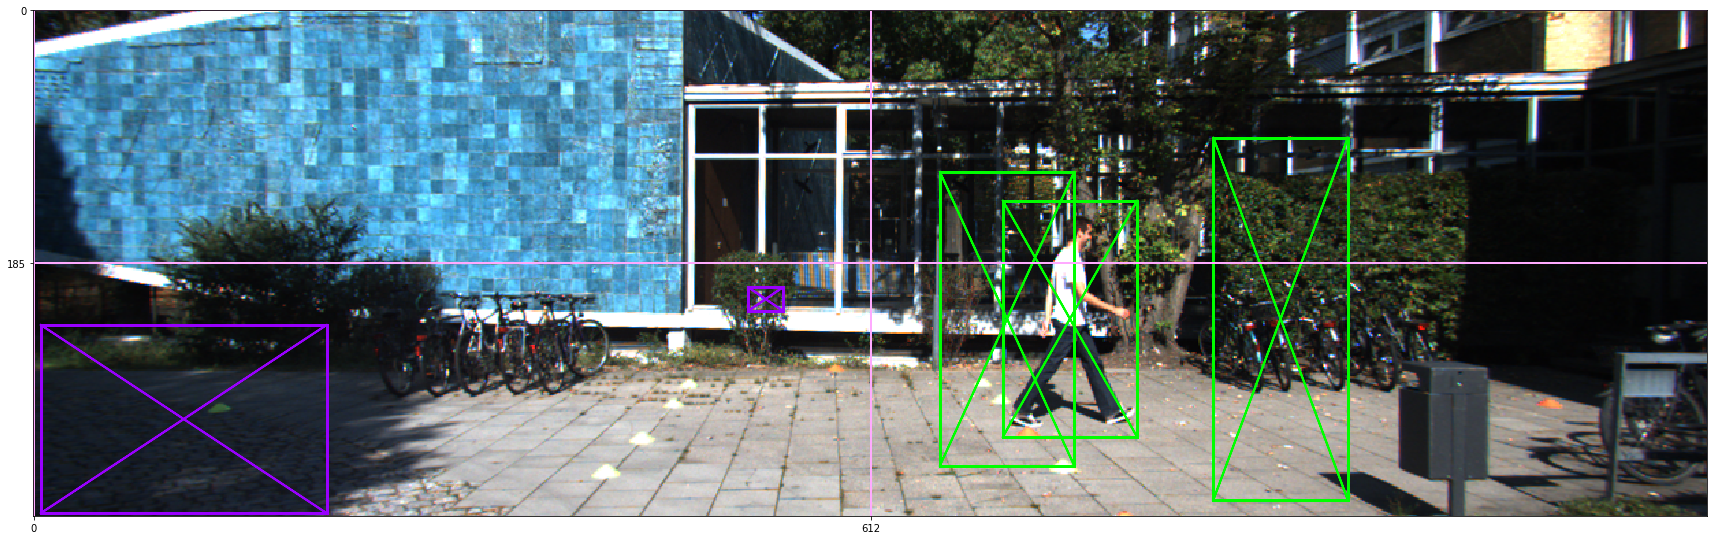

----------------------------------------------------------------------
|type            |  x_max     |  y_min     |  y_max     |  x_min     |
----------------------------------------------------------------------
----------------------------------------------------------------------
|Pedestrian      |  960.73    |  93.0      |  357.92    |  862.4     |
----------------------------------------------------------------------
|Pedestrian      |  760.73    |  118.0     |  332.92    |  662.4     |
----------------------------------------------------------------------
|Pedestrian      |  806.73    |  139.0     |  311.92    |  708.4     |
----------------------------------------------------------------------
|DontCare        |  214.12    |  229.89    |  367.61    |  5.0       |
----------------------------------------------------------------------
|DontCare        |  547.77    |  202.35    |  219.71    |  522.25    |
----------------------------------------------------------------------
batch_

In [33]:
# May have a look tf.count_nonzero to create the 1 operator: https://www.tensorflow.org/api_docs/python/tf/count_nonzero
# E.g. https://stackoverflow.com/a/43960630

# Interesting implementation of YOLO loss: https://github.com/johnwlambert/YoloTensorFlow229/blob/master/YoloTensorFlowFunctions.py
LAMBDA_COORD = 5
LAMBDA_NOOBJ = 0.5

im_id_1 = 0
im_id_2 = 3

S_test = 2
B_test = 3
C_test = 9

im = import_im(im_id_1, 'train')
im_shape = im.shape

labels_original = import_labels(im_id_1, 'train')

im_gt_labels, _ = convert_labels_to_array(labels_original, S_test, B_test, im_shape)

# --- Mix two labels from two different images ---
# labels_to_mix = import_labels(im_id_2, 'train')

# --- Create a second box in the image to test the IoU
#expand_box = -20
#labels_to_mix = import_labels(im_id_1, 'train')
#labels_to_mix[0]['bbox'] = {'x_max': 810.73 + expand_box,
#                            'x_min': 712.4 - expand_box,
#                            'y_max': 307.92 + expand_box,
#                            'y_min': 143.0 - expand_box}

# --- Move new box ---
move_box = 150
move_box_2 = 50
labels_to_mix = import_labels(im_id_1, 'train')
labels_to_mix[0]['bbox'] = {'x_max': 810.73 + move_box,
                            'x_min': 712.4 + move_box,
                            'y_max': 307.92 + move_box/3 ,
                            'y_min': 143.0 - move_box/3}

labels_to_mix_2 = import_labels(im_id_1, 'train')
labels_to_mix_2[0]['bbox'] = {'x_max': 810.73 - move_box_2,
                            'x_min': 712.4 - move_box_2,
                            'y_max': 307.92 + move_box_2/2,
                            'y_min': 143.0 - move_box_2/2}

labels_to_mix = labels_to_mix + labels_to_mix_2

labels = labels_original + labels_to_mix + import_labels(im_id_2, 'train')

small_variation = 4
labels[0]['bbox'] = {'x_max': 810.73 - small_variation,
                     'x_min': 712.4 - small_variation,
                     'y_max': 307.92 + small_variation,
                     'y_min': 143.0 - small_variation}

mix_labels, _ = convert_labels_to_array(labels, S_test, B_test, im_shape)

gt_labels = np.stack((im_gt_labels, im_gt_labels),axis=0)
pred_labels = np.stack((im_gt_labels, mix_labels),axis=0)

labels_converted_back = convert_array_to_labels(mix_labels, S_test, B_test, im_shape)

display_im(im, labels_converted_back, num_cell_grid = S_test)

sess = tf.InteractiveSession()

tf_ground_truth_labels = tf.convert_to_tensor(gt_labels)
tf_pred_labels = tf.convert_to_tensor(pred_labels)
compute_YOLOv1_loss(tf_pred_labels, tf_ground_truth_labels, S_test, B_test, C_test)

sess.close()

In [35]:
S_test2 = 2
B_test2 = 2
C_test2 = 2

im_true_labels = [0, 0, 0, 0, 0,   # 1st grid cell
                 0, 0, 0, 0, 0,
                 0, 0,
                 0, 0, 0, 0, 0,    # 2nd grid cell
                 0, 0, 0, 0, 0,
                 0, 0,
                 0, 0, 0, 0, 0,    # 3rd grid cell
                 0, 0, 0, 0, 0,
                 0, 0,
                 0.25, 0.25, 0.1, 0.4, 1,    # 4rd grid cell
                 0, 0, 0, 0, 0,
                 1, 0]

im_pred_labels = [0, 0, 0, 0, 0,   # 1st grid cell
                 0, 0, 0, 0, 0,
                 0, 0,
                 0, 0, 0, 0, 0,    # 2nd grid cell
                 0, 0, 0, 0, 0,
                 0, 0,
                 0, 0, 0, 0, 0,    # 3rd grid cell
                 0, 0, 0, 0, 0,
                 0, 0,
                 0.2, 0.25, 0.1, 0.4, 1,    # 4rd grid cell
                 0, 0, 0, 0, 0,
                 1, 0]

sess = tf.InteractiveSession()

tf_true_labels = tf.convert_to_tensor(im_true_labels)
print_tensor('tf_true_labels', tf_true_labels)

tf_pred_labels = tf.convert_to_tensor(im_pred_labels)
compute_YOLOv1_loss(tf_pred_labels, tf_true_labels, S_test2, B_test2, C_test2)

sess.close()

tf_true_labels.shape: (48,)
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.25        0.25        0.1         0.40000001  1.          0.
  0.          0.          0.          0.          1.          0.        ]
batch_size: 1
mask_bigger_iou.shape: (1, 4, 2)
[[[ 0.  0.]
  [ 0.  0.]
  [ 0.  0.]
  [ 1.  0.]]]
center_coord_loss.shape: (1, 4, 2)
[[[ 0.      0.    ]
  [ 0.      0.    ]
  [ 0.      0.    ]
  [ 0.0025  0.125 ]]]
box_loss.shape: (1,)
[ 0.0125]
object_loss.shape: (1,)
[ 0.]
no_object_loss.shape: (1,)
[ 0.]
mask_cell_has_object.shape: (1, 4, 1)
[[[ 0.]
  [ 0.]
  [ 0.]
  [ 1.]]]
class_loss.shape: (1,)
[ 0.]
total_loss.shape: (1,)
[ 0.